# Loading environment

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import pandas as pd
import seaborn as sns
import subprocess as sp
import os

Populating the interactive namespace from numpy and matplotlib


# Import of files

In [2]:
df=pd.DataFrame([])

### Rosetta score file

outscore=r"./out/score.sc"
if (os.path.exists(outscore)):
    columns_to_keep = ['ddg_pre','ddg_post','nddg_pre','nddg_post','hbonds_pre','hbonds_post', 'bunsh_pre','bunsh_post',
    'bunsh2_pre','bunsh2_post', 'sc_pre','sc_post', 'sasa_pre','sasa_post', 'cms_pre','cms_post', 'description']
    df = pd.read_csv(outscore, sep='\s+', skiprows=1)
    df = df[df.total_score != 'total_score'].drop(columns=[col for col in df.columns if col not in columns_to_keep])
    df = df.applymap(lambda x : pd.to_numeric(x,errors='ignore'))

    df1=pd.DataFrame([])
    dico_seedname={}

    for idx in df.index:
        description=df.loc[idx,'description']
        splited_description=df.loc[idx,'description'].split('_')
        seed=splited_description[2] +'_'+splited_description[3] +'_'+splited_description[4]
        dico_seedname[description]=seed
        
    df['seed'] = df['description'].map(dico_seedname)
    df['nddg_pre']=df['ddg_pre']/df['sasa_pre']*1000
    df['nddg_post']=df['ddg_post']/df['sasa_post']*1000

### Similarity score    
    
outsimi='./similarity.csv'
dico_unique={}
dico_cn={}
if (os.path.exists(outsimi)):
    df2 = pd.read_csv(outsimi, sep=',').dropna()
    for idx in df2.index:
        name=df2.loc[idx,'design']
        uniqueness=df2.loc[idx,'similarity']
        closest_neighboor=df2.loc[idx,'best_match']
        dico_unique[name]=uniqueness
        dico_cn[name]=closest_neighboor
    df['similarity'] = df['description'].map(dico_unique)
    df['closest_neighboor'] = df['description'].map(dico_cn)

### Contacts to molecule

outcontacts='contacts.csv'
dico_contacts={}
if (os.path.exists(outcontacts)):
    df3 = pd.read_csv(outcontacts, sep=',').dropna()
    for idx in df3.index:
        name=df3.loc[idx,'design']
        contacts=df3.loc[idx,'mol_contacts']
        dico_contacts[name]=contacts
    df['mol_contacts'] = df['description'].map(dico_contacts)

### DSSP ratio (Beta sheet-seed only)

outdssp='dssp.csv'
dico_dssp={}
if (os.path.exists(outdssp)):
    df4 = pd.read_csv(outdssp, sep=',').dropna()
    for idx in df4.index:
        name=df4.loc[idx,'design']
        ratio=df4.loc[idx,'ratio']*100
        dico_dssp[name]=ratio
    df['dssp_ratio'] = df['description'].map(dico_dssp)

In [3]:
df.head(5)

,bunsh2_post,bunsh2_pre,bunsh_post,bunsh_pre,cms_post,cms_pre,ddg_post,ddg_pre,hbonds_post,hbonds_pre,...,sasa_pre,sc_post,sc_pre,description,seed,nddg_pre,nddg_post,similarity,closest_neighboor,mol_contacts
0,1.0,0.0,0.0,1.0,120.812,120.431,-10.364,-10.571,0.0,0.0,...,779.036,0.523,0.565,6O0K_A_102520-1fw9_A_2,102520-1fw9_A_2,-13.569334,-13.206518,0.166667,6O0K_A_102225-3r6f_A_9,15
1,4.0,5.0,3.0,4.0,159.773,166.738,-17.519,-16.702,2.0,2.0,...,1003.671,0.668,0.663,6O0K_A_104007-1yj5_C_0,104007-1yj5_C_0,-16.640911,-18.257650,0.500000,6O0K_A_104427-1stz_A_0,4
2,4.0,3.0,4.0,2.0,132.160,128.324,-10.734,-8.957,4.0,4.0,...,770.544,0.506,0.671,6O0K_A_100210-1pfz_A_0,100210-1pfz_A_0,-11.624255,-13.293241,0.500000,6O0K_A_104427-1stz_A_0,6
3,5.0,4.0,1.0,1.0,130.515,134.496,-11.824,-11.298,4.0,4.0,...,836.058,0.575,0.605,6O0K_A_100101-3s2k_A_1,100101-3s2k_A_1,-13.513417,-14.240739,0.400000,6O0K_A_101921-2vsd_A_1,9
4,4.0,4.0,3.0,3.0,99.435,98.777,-14.583,-13.639,4.0,4.0,...,911.758,0.439,0.460,6O0K_A_100882-2e6x_A_3,100882-2e6x_A_3,-14.959013,-16.184883,0.428571,6O0K_A_102225-3r6f_A_3,18


# Metrics analysis
This section analyzes the improvement of each Rosetta metrics after design compared to the metrics prior design.

In [4]:
#You can add other metrics there, as long as there is a '_pre' and '_post' suffix
metrics = [['ddg_pre','ddg_post'],['nddg_pre','nddg_post'],['hbonds_pre','hbonds_post'], 
           ['bunsh_pre','bunsh_post'],['bunsh2_pre','bunsh2_post'], ['sc_pre','sc_post'], ['sasa_pre','sasa_post'],
          ['cms_pre','cms_post']]

# Don't touch this part
pre_data = pd.DataFrame([])
post_data = pd.DataFrame([])
comparison = pd.DataFrame([])

for metric in metrics:
    for element in metric:
        name = element.split('_')
        if name[1] == 'pre':
            pre_data[name[0]] = df.loc[:,element]
        elif name[1] == 'post':
            post_data[name[0]] = df.loc[:,element]
            comparison[name[0]] = (post_data[name[0]]>pre_data[name[0]])

pre_data["Data"] = "Pre-design"
post_data["Data"] = "Post-design"
all_data = pd.concat([pre_data, post_data])           

In [5]:
def make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y):
    #Boxplot
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    plt.subplots_adjust(wspace=0.5)
    g1 = sns.boxplot(x="Data", y=metric, hue="Data", data=all_data, showfliers = False, ax=axs[0])
    axs[0].set_xlabel(boxlabel_x)
    axs[0].set_ylabel(boxlabel_y)

    #Scatterplot
    g2 = sns.scatterplot(x=df['{}_pre'.format(metric)],y=df['{}_post'.format(metric)], hue=comparison[metric],legend = False, ax=axs[1])
    axis=[g2.get_xlim(), g2.get_ylim()]
    g2.set_xlim(left=min(min(axis)), right=max(max(axis)))
    g2.set_ylim(bottom=min(min(axis)), top=max(max(axis)))
    x0, y0 = g2.get_xlim()
    x1, y1 = g2.get_ylim()
    axs[1].set_xlabel(scattlabel_x)
    axs[1].set_ylabel(scattlabel_y)
    axs[1].plot([x0, y0], [x1, y1], 'k--')

    # Statistics
    pre_medi=pre_data[metric].median()
    post_medi=post_data[metric].median()
    print(f"Median pre-design: {pre_medi:.2f} / Median post-design: {post_medi:.2f}")

### Computer binding energy (ddG)

Median pre-design: -15.96 / Median post-design: -16.93


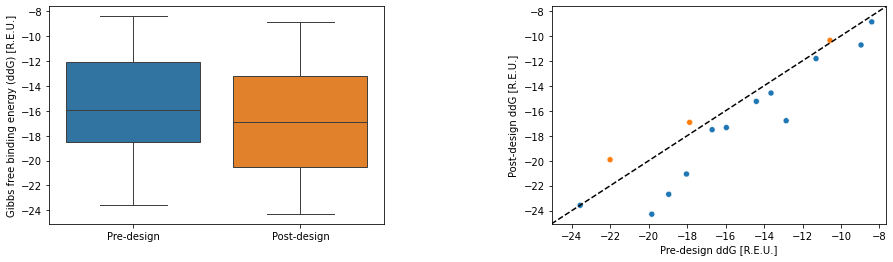

In [6]:
metric = "ddg"
boxlabel_x = ''
boxlabel_y = 'Gibbs free binding energy (ddG) [R.E.U.]'
scattlabel_x = 'Pre-design ddG [R.E.U.]'
scattlabel_y = 'Post-design ddG [R.E.U.]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### dSASA-normalized ddG

Median pre-design: -16.64 / Median post-design: -16.18


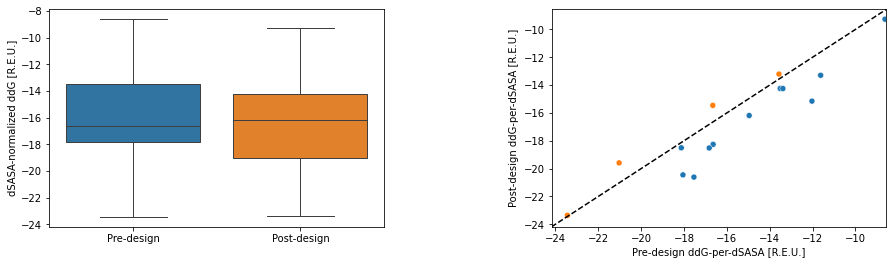

In [7]:
metric = "nddg"
boxlabel_x = ''
boxlabel_y = 'dSASA-normalized ddG [R.E.U.]'
scattlabel_x = 'Pre-design ddG-per-dSASA [R.E.U.]'
scattlabel_y = 'Post-design ddG-per-dSASA [R.E.U.]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Interface hydrogen bonds

Median pre-design: 4.00 / Median post-design: 4.00


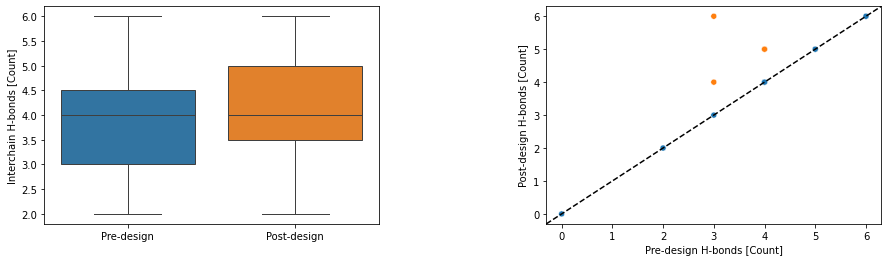

In [8]:
metric = "hbonds"
boxlabel_x = ''
boxlabel_y = 'Interchain H-bonds [Count]'
scattlabel_x = 'Pre-design H-bonds [Count]'
scattlabel_y = 'Post-design H-bonds [Count]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Buried unsatisfied polar atoms (Filter #1)

Median pre-design: 4.00 / Median post-design: 3.00


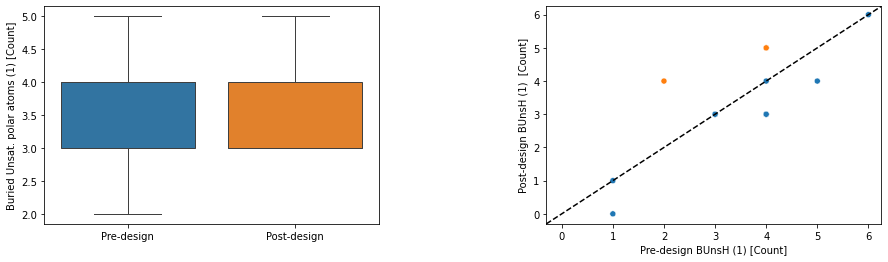

In [9]:
metric = "bunsh"
boxlabel_x = ''
boxlabel_y = 'Buried Unsat. polar atoms (1) [Count]'
scattlabel_x = 'Pre-design BUnsH (1) [Count]'
scattlabel_y = 'Post-design BUnsH (1)  [Count]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Buried unsatisfied polar atoms (Filter #2)

Median pre-design: 5.00 / Median post-design: 5.00


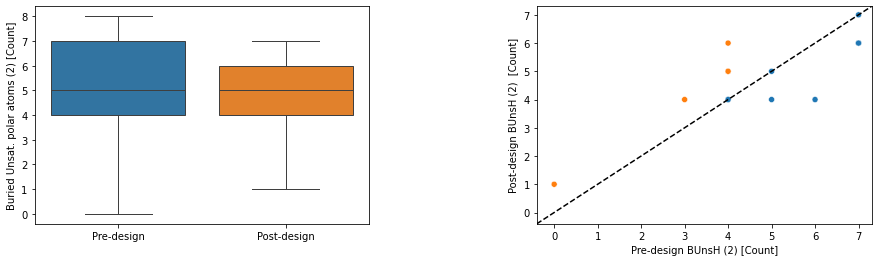

In [10]:
metric = "bunsh2"
boxlabel_x = ''
boxlabel_y = 'Buried Unsat. polar atoms (2) [Count]'
scattlabel_x = 'Pre-design BUnsH (2) [Count]'
scattlabel_y = 'Post-design BUnsH (2)  [Count]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Shape complementarity

Median pre-design: 0.63 / Median post-design: 0.60


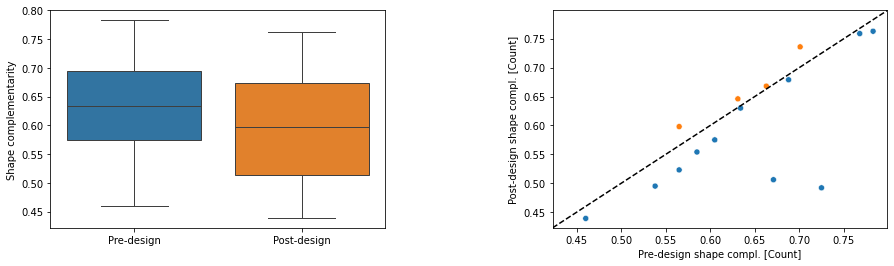

In [11]:
metric = "sc"
boxlabel_x = ''
boxlabel_y = 'Shape complementarity'
scattlabel_x = 'Pre-design shape compl. [Count]'
scattlabel_y = 'Post-design shape compl. [Count]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Buried surface area (dSASA)

Median pre-design: 1003.67 / Median post-design: 959.54


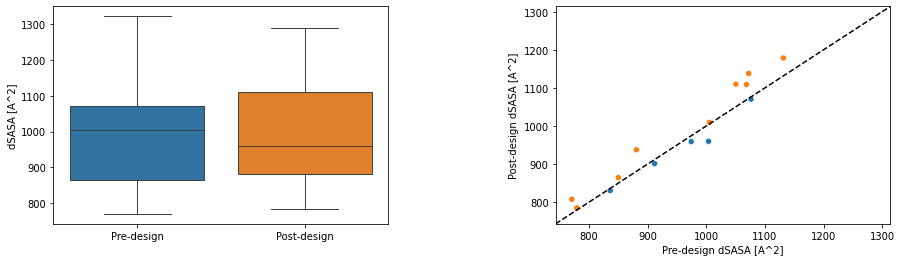

In [12]:
metric = "sasa"
boxlabel_x = ''
boxlabel_y = 'dSASA [A^2]'
scattlabel_x = 'Pre-design dSASA [A^2]'
scattlabel_y = 'Post-design dSASA [A^2]'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Contact molecular surface (CMS)

Median pre-design: 174.29 / Median post-design: 176.12


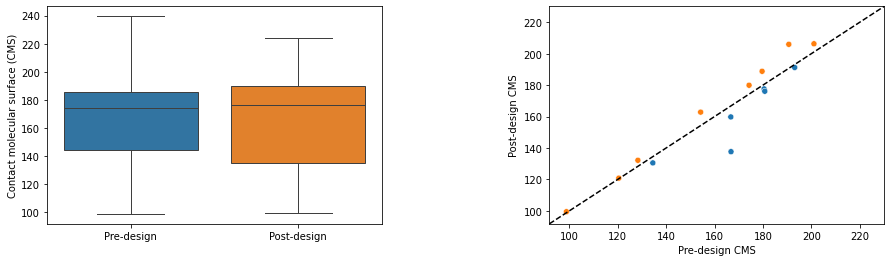

In [13]:
metric = "cms"
boxlabel_x = ''
boxlabel_y = 'Contact molecular surface (CMS)'
scattlabel_x = 'Pre-design CMS'
scattlabel_y = 'Post-design CMS'

make_plot(all_data, metric, boxlabel_x, boxlabel_y, scattlabel_x, scattlabel_y)

### Similarity score, small molecule contacts and beta sheet ratio
The **similarity** score gives an alignement score with all other seeds. A score of 0 is a unique seed, while a score of 1 means the seed is identical with another one.

The **small molecule atom contacts** give the number of atoms that the seed has in contact with the target drug. This ensures that at a minimum contact is performed by the seed with the small molecule.

The **beta sheet ratio** is only computed and meaningful for beta sheet-based seeds as the subsequent grafting steps will crop loop regions to increase grafting efficiency. Therefore, only seeds with a high number of beta sheet-based contacts should be selected.


Similarity median: 0.45
Small molecule contacts median: 11.00


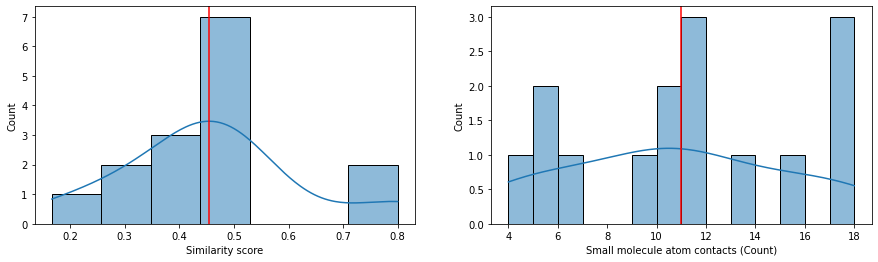

In [14]:
if 'dssp_ratio' in df:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
else: 
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplots_adjust(wspace=0.2)
    
g1=sns.histplot(df['similarity'], kde=True, ax = axs[0])
g1.axvline(df['similarity'].median(), color='red')
axs[0].set_xlabel('Similarity score')

g2=sns.histplot(df['mol_contacts'], kde=True, binwidth=1, ax = axs[1])
g2.axvline(df['mol_contacts'].median(), color='red')
axs[1].set_xlabel('Small molecule atom contacts (Count)')

if 'dssp_ratio' in df:
    g3=sns.histplot(df['dssp_ratio'], kde=True, ax = axs[2])
    g3.axvline(df['dssp_ratio'].median(), color='red')
    axs[2].set_xlabel('Beta sheet contact (%)')
    print(f"Beta sheet contact percentage median: {df['dssp_ratio'].median():.2f}%")
    
print(f"Similarity median: {df['similarity'].median():.2f}")
print(f"Small molecule contacts median: {df['mol_contacts'].median():.2f}")

# Selection

This part aims to select the best seeds based on the different metrics used. You can use the default recommended cutoffs (Usually the quartile) or using your own cutoffs.

If two seeds are highly similar (Similarity score > 0.7), only the one with the best dSASA-normalized binding energy (norm. ddG) will be kept.

### Setting the cutoffs

In [61]:
default_cutoff={'ddg_post': df['ddg_post'].quantile(q=0.75), 
         'nddg_post' : df['nddg_post'].quantile(q=0.75),
         'bunsh_post': df['bunsh_post'].quantile(q=0.75),
         'bunsh2_post': df['bunsh2_post'].quantile(q=0.75), 
         'sc_post': df['sc_post'].quantile(q=0.25),
         'hbonds_post': df['hbonds_post'].quantile(q=0.25),
         'sasa_post' : df['sasa_post'].quantile(q=0.25),
         'mol_contacts' : df['mol_contacts'].quantile(q=0.25),
         'dssp_ratio' : 66}

customed_cutoff={'ddg_post': -24, 
         'nddg_post': -23,
         'bunsh_post': 1,
         'bunsh2_post': 2, 
         'sc_post': 0.6,
         'hbonds_post': 3,
         'sasa_post' : 1000,
         'mol_contacts' : 5,
         'dssp_ratio' : 60}

### Making a selection

In [62]:
def make_selection(df, cutoff):
    select=df[(df['ddg_post'] <= cutoff['ddg_post']) & 
          (df['nddg_post'] <= cutoff['nddg_post']) & 
          (df['bunsh_post'] <= cutoff['bunsh_post']) & 
          (df['bunsh2_post'] <= cutoff['bunsh2_post']) & 
          (df['sc_post'] >= cutoff['sc_post']) &
          (df['hbonds_post'] >= cutoff['hbonds_post']) & 
          (df['sasa_post'] >= cutoff['sasa_post']) & 
          (df['mol_contacts'] >= cutoff['mol_contacts'])]
    if 'dssp_ratio' in df:
        select=select[select['dssp_ratio']>=cutoff['dssp_ratio']]
    return select

In [63]:
select = make_selection(df, default_cutoff)
#select = make_selection(df, customed_cutoff)

to_drop=[]
for idx in select.index:
    if select.at[idx,'similarity'] > 0.7:
        closest=select.at[idx,'closest_neighboor']
        if select['description'].str.contains(closest).any():
            if (len(select.index[select['description'] == closest].to_list())!=0):
                idx2=select.index[select['description'] == closest].to_list()[0]
            ddg1=select.at[idx,'nddg_post']
            ddg2=select.at[idx2,'nddg_post']
            if ddg1<=ddg2:
                to_drop.append(idx2)
            else:
                to_drop.append(idx)

select.drop(index=to_drop, inplace=True)                

print(r"Number of seeds selected: {}".format(select.shape[0]))
select.head(10)

Number of seeds selected: 1


C:\Users\antho\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,bunsh2_post,bunsh2_pre,bunsh_post,bunsh_pre,cms_post,cms_pre,ddg_post,ddg_pre,hbonds_post,hbonds_pre,...,sasa_pre,sc_post,sc_pre,description,seed,nddg_pre,nddg_post,similarity,closest_neighboor,mol_contacts
5,6.0,7.0,3.0,4.0,188.816,179.679,-22.69,-18.959,4.0,3.0,...,1050.463,0.763,0.783,6O0K_A_102225-3r6f_A_9,102225-3r6f_A_9,-18.048232,-20.449234,0.8,6O0K_A_102225-3r6f_A_3,11


### Copying the selected files

In [66]:
cmd = r"cp "+ ''.join('./out/' + select['description'] + ".pdb ") + './selected'
output = sp.run(cmd, shell=True, capture_output=True, text=True)
print(cmd)

cp ./out/6O0K_A_102225-3r6f_A_9.pdb ./selected
